# Exploratory Data Analysis
***

- To develop a hypothesis for the data set we first create a histrogram of 15 most frequent tokens. They will help us understand a trend in the tweets.
- On initial analysis some words like http, vs, play, win, iphone appear very frequent but are not relevant as they come from tweets sharing links or asking people to join a game or website to win free merchandise. These keywords are thus added to the existing list of stopwords.
- The next step in the EDA process is to generate frequency distribution plot for bigrams. These will give us an idea of which tokens appear together. We use raw frequency as the bigram measure and then pick the top 15 bigrams to be plotted.
- Another intersting observation is that upon lemmatization, we get some bigrams like "x_x" which make no sense (in the XR data set). This goes to show that lemmatization and stemming should be done carefully and are not approaches that should be apllied blindly to data sets.

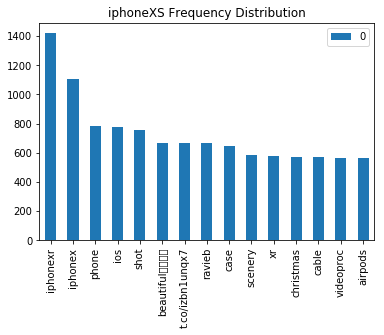

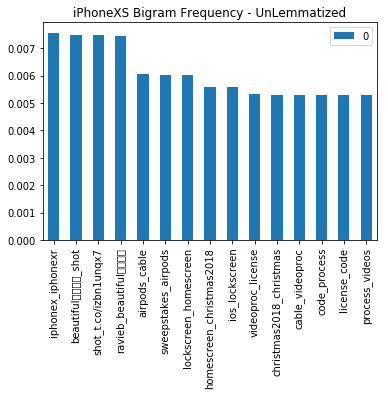

In [6]:
# plot charts inline
%matplotlib inline

import os
import nltk
import string
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder

# change this to work with a different local file
TEXT_FILE = r"data\iPhoneXS_twitter_eda.csv"
# a few additional stop words based on context
EXTRA_STOP_WORDS = ["1", "2", "3", "x", "http", "https", "iphone", "iphoneXS", "apple", "iphonexs", "XS", "xs", "vs", "iphonexsmax", "wallpapers", "free", "download", "one", "'iphon…",
                    "enter", "chance", "win", "64", "gb", "via", "youtube", "comparison", "new", "play", "max", "wallpaper", "ar72014", "’"]
# generate frequency distribution for N words
TOKEN_COUNT = 15

def generate_freq_distro(file):
    ''' given a csv file with some text
        generate a frequency distribution graph 
        of N common words '''

    data = pd.read_csv(file)
    text = ','.join(data["text"])
    
    all_tokens = get_unigrams(text, EXTRA_STOP_WORDS)
    frequency = nltk.FreqDist(all_tokens)
    
    return frequency

def prepare_tokens(file, lemmatize=True):
    ''' given a csv file with text
        generates lemmatized tokens '''
    
    data = pd.read_csv(file)
    text = ','.join(data["text"])
    
    tokens = lemmatize_words(text, EXTRA_STOP_WORDS) if lemmatize else get_unigrams(text, EXTRA_STOP_WORDS)

    return tokens

def generate_bigrams(tokens):
    ''' given a list of tokens generates bigrams 
        Citation: https://avidml.wordpress.com/2017/08/03/word-cloud-with-frequently-occurring-bigrams-and-salient-bigrams/ '''


    # setup and score the bigrams using the raw frequency.
    finder = BigramCollocationFinder.from_words(tokens)
    bigram_measures = BigramAssocMeasures()
    scored = finder.score_ngrams(bigram_measures.raw_freq)

    # By default finder.score_ngrams is sorted, however don't rely on this default behavior.
    # Sort highest to lowest based on the score.
    scoredList = sorted(scored, key=itemgetter(1), reverse=True)

    # word_dict is the dictionary we'll use for the word cloud.
    word_dict = {}

    listLen = len(scoredList)

    # Get the bigram and make a contiguous string for the dictionary key. 
    # Set the key to the scored value. 
    for i in range(listLen):
        word_dict['_'.join(scoredList[i][0])] = scoredList[i][1]

    # the bigrams are joined using an underscore
    # as w/o it they don't make sense on the word-cloud
    return word_dict

def plot_barchart(freq_dist, plot_title="Frequency Distribution"):
    ''' given a freq dist dict, plot a bar chart with provided title '''

    freq_df = pd.DataFrame(list(freq_dist.values()), freq_dist.keys())
    freq_df.plot(kind="bar", title=plot_title)

    plt.show()
    
def get_unigrams(text, extra_stop_words=None):  
    stop = stopwords.words()
    if extra_stop_words is not None:
        stop += extra_stop_words

    tokens = nltk.word_tokenize(text)
    tokens = [token.strip(string.punctuation) for token in tokens]
    
    #removing stopwords
    tokens = [item for item in tokens if item not in stop]
    
    #remove empty tokens
    tokens=[token.strip() for token in tokens if token.strip() != '']
    
    return tokens

#function used for wordnet tagging
def get_wordnet_pos(pos_tag):
    # if pos tag starts with 'J'
    if pos_tag.startswith('J'):
        # return wordnet tag "ADJ"
        return wordnet.ADJ

    # if pos tag starts with 'V'
    elif pos_tag.startswith('V'):
        # return wordnet tag "VERB"
        return wordnet.VERB

    # if pos tag starts with 'N'
    elif pos_tag.startswith('N'):
        # return wordnet tag "NOUN"
        return wordnet.NOUN

    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        # be default, return wordnet tag "NOUN"
        return wordnet.NOUN

def lemmatize_words(text, extra_stop_words=None):
    stop_words = stopwords.words('english')
    if extra_stop_words is not None:
        stop_words += extra_stop_words

    tokens = nltk.word_tokenize(text)
    tagged_tokens= nltk.pos_tag(tokens)
    wordnet_lemmatizer = WordNetLemmatizer()
    
    # lemmatize all words in the tagged tokens removing stopwords & punctuation
    lemmatized_words=[wordnet_lemmatizer.lemmatize\
            (word, get_wordnet_pos(tag)) \
            # tagged_tokens is a list of tuples (word, tag)
            for (word, tag) in tagged_tokens \
            # remove stop words
            if word not in stop_words and \
            word not in string.punctuation]
    
    return lemmatized_words

if __name__ == "__main__":

    # 1. plot barchart for unigrams
    freq_dist = generate_freq_distro(os.path.abspath(TEXT_FILE))
    freq_dist = dict(freq_dist.most_common(TOKEN_COUNT))

    plot_barchart(freq_dist, "iphoneXS Frequency Distribution")

    # 2. plot barchart for bigrams
    tokens = prepare_tokens(os.path.abspath(TEXT_FILE), lemmatize=False)
    bigrams = generate_bigrams(tokens)
    bigram_freq_dict = {k:v for k, v in list(bigrams.items())[0:TOKEN_COUNT]}

    plot_barchart(bigram_freq_dict, "iPhoneXS Bigram Frequency - UnLemmatized")
